<a href="https://colab.research.google.com/github/ms03831/nn-HoG-classification-CIFAR10/blob/master/classification_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import tensorflow as tf 
tf.__version__

'2.2.0-rc2'

In [0]:
from tensorflow.keras.datasets import cifar10
from matplotlib import pyplot as plt
import cv2
import pandas as pd 
from google.colab.patches import cv2_imshow
from sklearn import svm
import random
from keras.utils.np_utils import to_categorical
import numpy as np

# 1. Loading Dataset:
- ##  About the dataset:
The CIFAR-10 dataset is an image dataset that consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

- ##  preprocessing steps for image data: 
  - resizing 
  - mean-normalisation 
  - capping the RBG values between 0, 1 (0 corresponds to 0 and 1 corresponds to 255)
  - removing noise by applying some filter such as guassian blur/smoothing.


In [14]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Shape of training data:")
print(x_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(x_test.shape)
print(y_test.shape)


Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


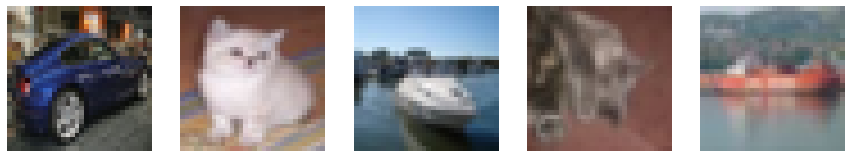

In [15]:
f, ax = plt.subplots(1, 5, figsize=(15, 5))

indexes = random.choices(list(range(0, x_train.shape[0])), k = 5)
for j, i in enumerate(indexes):
  ax[j].imshow(x_train[i])
  ax[j].axis('off')
plt.show()

# 2. Filt
Write a function "filt" whose aim would be to perform the task of filtering. The function should take the
following arguments: input, filter, padding, normalization. The 'input' would be the numpy representation
of an image over which filtering is to be performed - this will either have a single channel or three channels,
'filter' would be a 2D numpy array representing the filter (for example: np.array([[1, 1, 1], [1, 1, 1], [1, 1,
1]]), 'padding' would be a boolean value which would determine as to whether the output image should
have the same size as the input image, and 'normalization' would again be a boolean value which would
determine as to whether the filtering operation needs to be normalized or not. The output of this function
should be the filtered image. Also note that the only external library which can be used in this function is
"numpy"

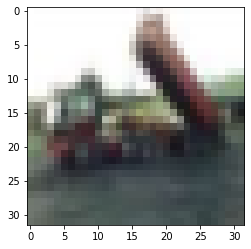

(32, 32, 3)


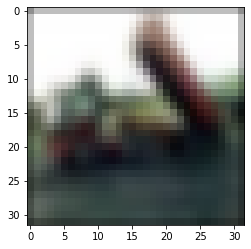

(32, 32, 3)


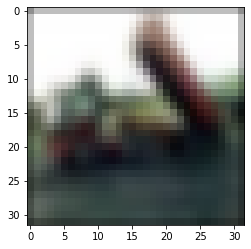

In [24]:
def filt(input, filter, padding, normalization):
    """
    param: input - numpy representation of an input image 
    param: filter - 2D numpy array representing the filter  
    param: padding -  boolean value as to whether the output image should have the same size as the input image
    param: normalization - boolean value as to whether the filtering operation needs to be normalized or not. 
    return: returns the filtered image, as np array
    """
    if len(input.shape) == 2: 
        f_shape = filter.shape + (1,)
        i_shape = input.shape + (1,)
        filter = filter.reshape(f_shape)
        input = input.reshape(i_shape)
        
    n_1, n_2, n_3 = filter.shape
    w, h, d = input.shape
    input = np.array(input, dtype=np.float32)
    v_min = input.min(axis=(0, 1), keepdims=True)
    v_max = input.max(axis=(0, 1), keepdims=True)
    input = (input - v_min)/(v_max - v_min)
    x2 = input
    if padding:
        padding_w = (n_1 - 1)//2
        padding_h = (n_2 - 1)//2
        zero_pad_w = np.zeros((w, padding_w, d))
        input = np.concatenate((zero_pad_w, input, zero_pad_w), axis=1)
        zero_pad_h = np.zeros((padding_h, input.shape[1], d))
        input = np.concatenate((zero_pad_h, input, zero_pad_h), axis=0)
    w, h, d = input.shape
    
    new_shape = (w - n_1 + 1, h - n_2 + 1, d)
    new_image = np.zeros(new_shape)
    
    if normalization:
        n = np.sum(filter[:, :, 0])
        filter = filter/n
    for i in range(w-n_1+1):
        for j in range(h-n_2+1):
          for k in range(d):
              new_image[i][j][k] = np.sum(input[i:i+n_1, j:j+n_2, k] * filter[:, :, k])
    if new_image.shape[-1] == 1:
        shape = new_image.shape[:2]
        new_image = new_image.reshape(shape)
    print(new_image.shape)
    plt.imshow(new_image)#, cmap = 'gray')
    plt.show()

#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
img = np.array(x_train[2])
plt.imshow(img)#, cmap = 'gray')
plt.show()
filter_guass = cv2.getGaussianKernel(3, 0)

filter_guass = np.dot(filter_guass, filter_guass.T)

filter_guass = np.array([filter_guass, filter_guass, filter_guass])
filter_guass = filter_guass.T
filt(img, filter_guass, True, False)
filt(img, filter_guass, True, True)

# 3. Extract HOG features from the CIFAR-10 dataset, and train a Linear SVM using those features.
### You are expected to reach around 45% accuracy on test data using this method. 

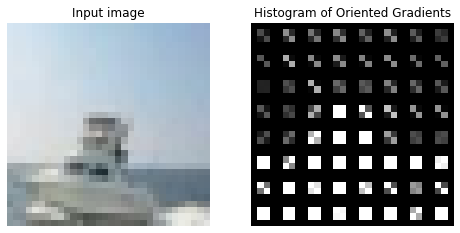

In [0]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

image = x_train[100]

fd, hog_image = hog(image, orientations=8, multichannel=True, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

def svm_training(xtrain, ytrain):
    """
    param: x_train: numpy array representation of train images
    param: y_train: one-hot encoded labels
    returns: trained SVM classifier
    """
    clf = svm.SVC(kernel='poly')
    clf.fit(xtrain, ytrain)
    return clf

def hog_features(img):
    fd, hog_image = hog(image, orientations=24, pixels_per_cell=(4, 4),
                    cells_per_block=(5, 5), visualize=True, multichannel=True)
    return hog_image

train_features = np.array([hog_features(img).flatten() for img in x_train])
test_features = np.array([hog_features(img).flatten() for img in x_test])
'''
clf = svm_training(train_features, y_train)
print(clf.predict(test_features[:10]), y_test[:10])
clf.score(test_features, y_test) 
'''
pd.DataFrame(train_features).to_csv("train_hog.csv", header=None, index=None)
pd.DataFrame(test_features).to_csv("test_hog.csv", header=None, index=None)

In [0]:

from sklearn.ensemble import RandomForestClassifier as rf

model = rf()
print('yes')
model.fit(train_features, y_train)
print(model.predict(test_features[:10]), y_test[:10])
model.score(test_features, y_test) 